In [2]:
# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

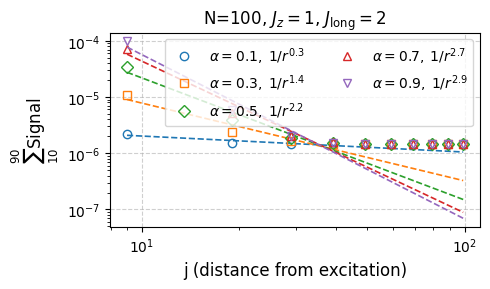

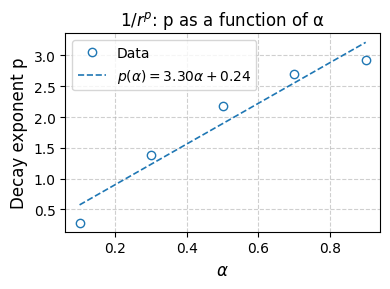

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 1

# Sweep positions j
J_values = np.arange(9, 100, 10)

# The alpha cases & filenames
alpha_cases = {
    0.1: "N100LFIMb2lcfara01VaryPos",
    0.3: "N100LFIMb2lcfara03VaryPos",
    0.5: "N100LFIMb2lcfara05VaryPos",
    0.7: "N100LFIMb2lcfara07VaryPos",
    0.9: "N100LFIMb2lcfara09VaryPos"
}

markers = ["o", "s", "D", "^", "v", "x", "p", "*", "h"]

alpha_list = []
exponent_list = []

plt.figure(figsize=(5, 3))

# ---------------------------------------------------
# MAIN LOG-LOG PLOT WITH FITS + EXPONENT LABELS
# ---------------------------------------------------
for idx, (alpha, prefix) in enumerate(alpha_cases.items()):
    tracked_signal = []
    marker = markers[idx % len(markers)]

    for J in J_values:
        file_path = os.path.join(base_path, f"{prefix}{J}.txt")
        raw_data = load_mathematica_data(file_path)

        n_steps = raw_data.shape[0]
        t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)

        signal_sum = raw_data[t_index, 8:90].sum()
        tracked_signal.append(signal_sum)

    tracked_signal = np.array(tracked_signal)

    # --- Fit first 4 points ---
    x_fit = J_values[:4]
    y_fit = tracked_signal[:4]

    logx = np.log(x_fit)
    logy = np.log(y_fit)

    b, a = np.polyfit(logx, logy, 1)  # log y = a + b log x
    p = -b                           # decay exponent

    alpha_list.append(alpha)
    exponent_list.append(p)

    # --- Plot data ---
    line = plt.loglog(
        J_values, tracked_signal,
        marker=marker,
        linestyle="",
        markersize=6,
        markerfacecolor="none",
        label=fr"$\alpha={alpha},\; 1/r^{{{p:.1f}}}$"
    )

    color = line[0].get_color()

    # --- Plot fitted curve in same color ---
    fit_curve = np.exp(a) * (J_values ** b)
    plt.loglog(
        J_values, fit_curve,
        "--", color=color, linewidth=1.2
    )

    # --- Annotate exponent p on plot ---
    # plt.text(
    #     J_values[2], fit_curve[2],
    #     fr"$p={p:.2f}$",
    #     color=color, fontsize=9
    # )

plt.xlabel("j (distance from excitation)", fontsize=12)
plt.ylabel(r"$\sum_{10}^{90}\mathrm{Signal}$", fontsize=12)
plt.title(r"N=100, $J_z=1$, $J_{\mathrm{long}}=2$", fontsize=12)
plt.grid(True, which="major", linestyle="--", alpha=0.6)
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig("plt/tracked_signal_vs_j_alphavaried.svg", dpi=150)
plt.show()


# ---------------------------------------------------
# EXPONENT VS ALPHA + FIT
# ---------------------------------------------------
alpha_arr = np.array(alpha_list)
p_arr = np.array(exponent_list)

plt.figure(figsize=(4, 3))

# Plot real data
line = plt.plot(
    alpha_arr, p_arr,
    "o", markersize=6,
    markerfacecolor="none",
    label="Data"
)
color = line[0].get_color()

# ---- Fit p(α) = c0 + c1 α ----
coeff = np.polyfit(alpha_arr, p_arr, 1)
c1, c0 = coeff[0], coeff[1]
p_fit = c1 * alpha_arr + c0

# Plot fitted dashed line in SAME color
plt.plot(
    alpha_arr, p_fit,
    "--", color=color, linewidth=1.2,
    label=fr"$p(\alpha)={c1:.2f}\alpha + {c0:.2f}$"
)

plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel("Decay exponent p", fontsize=12)
plt.title(r"$1/r^p$: p as a function of α")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("plt/tracked_signal_vs_j_alphavaried3.svg", dpi=150)
plt.show()


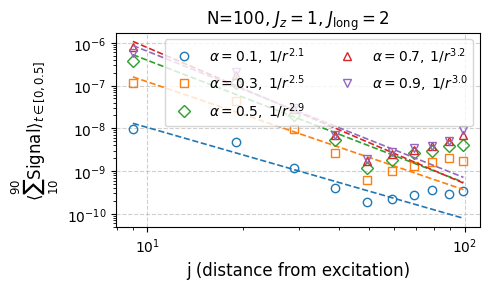

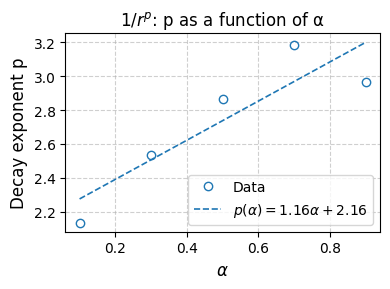

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------
# Parameters
# -----------------------------
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 0.5  # upper limit of time window

# Sweep positions j
J_values = np.arange(9, 100, 10)

# The alpha cases & filenames
alpha_cases = {
    0.1: "N100LFIMb2lcfara01VaryPos",
    0.3: "N100LFIMb2lcfara03VaryPos",
    0.5: "N100LFIMb2lcfara05VaryPos",
    0.7: "N100LFIMb2lcfara07VaryPos",
    0.9: "N100LFIMb2lcfara09VaryPos"
}

markers = ["o", "s", "D", "^", "v", "x", "p", "*", "h"]

# Lists to store decay exponents
alpha_list = []
exponent_list = []

plt.figure(figsize=(5, 3))

# ---------------------------------------------------
# MAIN LOG-LOG PLOT WITH FITS + EXPONENT LABELS
# ---------------------------------------------------
for idx, (alpha, prefix) in enumerate(alpha_cases.items()):
    tracked_signal = []
    marker = markers[idx % len(markers)]

    for J in J_values:
        file_path = os.path.join(base_path, f"{prefix}{J}.txt")
        raw_data = load_mathematica_data(file_path)   # shape: (T, N)

        n_steps = raw_data.shape[0]
        t_end_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)

        # ----------- TIME AVERAGING BLOCK (0 → 0.5) -----------
        # time_window shape: (t_end_index+1, 8:90)
        time_window = raw_data[0:t_end_index + 1, 10:99]

        # average over time, then sum over sites
        signal_avg = time_window.mean(axis=0).sum()

        tracked_signal.append(signal_avg)

    tracked_signal = np.array(tracked_signal)

    # --- Fit first 4 points ---
    x_fit = J_values[:4]
    y_fit = tracked_signal[:4]

    logx = np.log(x_fit)
    logy = np.log(y_fit)

    b, a = np.polyfit(logx, logy, 1)  # log y = a + b log x
    p = -b                            # decay exponent

    alpha_list.append(alpha)
    exponent_list.append(p)

    # --- Plot data ---
    line = plt.loglog(
        J_values, tracked_signal,
        marker=marker,
        linestyle="",
        markersize=6,
        markerfacecolor="none",
        label=fr"$\alpha={alpha},\; 1/r^{{{p:.1f}}}$"
    )

    color = line[0].get_color()

    # --- Plot fitted curve in same color ---
    fit_curve = np.exp(a) * (J_values ** b)
    plt.loglog(
        J_values, fit_curve,
        "--", color=color, linewidth=1.2
    )

plt.xlabel("j (distance from excitation)", fontsize=12)
plt.ylabel(r"$\langle \sum_{10}^{90}\mathrm{Signal} \rangle_{t \in [0,0.5]}$", fontsize=12)
plt.title(r"N=100, $J_z=1$, $J_{\mathrm{long}}=2$", fontsize=12)
plt.grid(True, which="major", linestyle="--", alpha=0.6)
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig("plt/tracked_signal_vs_j_alphavaried_timeavg.svg", dpi=150)
plt.show()


# ---------------------------------------------------
# EXPONENT VS ALPHA + FIT
# ---------------------------------------------------
alpha_arr = np.array(alpha_list)
p_arr = np.array(exponent_list)

plt.figure(figsize=(4, 3))

# Plot real data
line = plt.plot(
    alpha_arr, p_arr,
    "o", markersize=6,
    markerfacecolor="none",
    label="Data"
)
color = line[0].get_color()

# ---- Fit p(α) = c0 + c1 α ----
coeff = np.polyfit(alpha_arr, p_arr, 1)
c1, c0 = coeff[0], coeff[1]
p_fit = c1 * alpha_arr + c0

# Plot fitted dashed line in SAME color
plt.plot(
    alpha_arr, p_fit,
    "--", color=color, linewidth=1.2,
    label=fr"$p(\alpha)={c1:.2f}\alpha + {c0:.2f}$"
)

plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel("Decay exponent p", fontsize=12)
plt.title(r"$1/r^p$: p as a function of α")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
# plt.savefig("plt/tracked_signal_vs_j_alphavaried3_timeavg.svg", dpi=150)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio.v2 as imageio
import numpy as np
import os
from scipy.signal import find_peaks

frames = []


base_path = "src"
Jlong_values = np.arange(9, 100,10)
step_size = 0.01
steps_per_unit = 1 / step_size

for J in Jlong_values:
    file_path = os.path.join(base_path, f"N100LFIMb2lcfara05VaryPos{J}.txt")
    raw_data = load_mathematica_data(file_path)
    time_axis = np.arange(raw_data.shape[0]) / steps_per_unit

    fig, ax = plt.subplots(figsize=(5, 3))
    im = ax.imshow(
        np.clip(raw_data, 1e-11, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-10, vmax=np.nanmax(raw_data)),
        extent=[0, raw_data.shape[1], time_axis.min(), time_axis.max()],
        rasterized=True
    )
    ax.set_title(fr"$j={J}$")
    ax.set_xlabel("Site index")
    ax.set_ylabel("Time")
    plt.colorbar(im, ax=ax, label="Frobenius norm")
    plt.tight_layout()

    frame_path = f"plt/frames_profiles/frame_{J:02d}.png"
    plt.savefig(frame_path, dpi=300)
    plt.close(fig)
    frames.append(imageio.imread(frame_path))

imageio.mimsave("plt/heatmap_evolution.gif", frames, fps=4)
print("GIF saved as plt/heatmap_evolution.gif")


ModuleNotFoundError: No module named 'imageio'

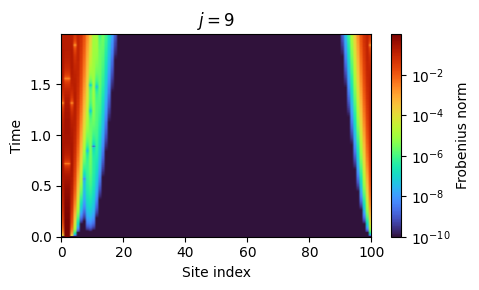

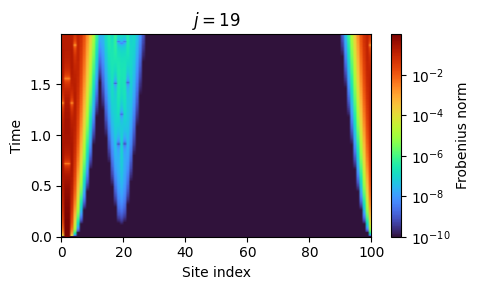

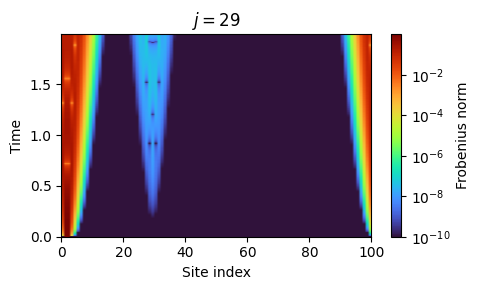

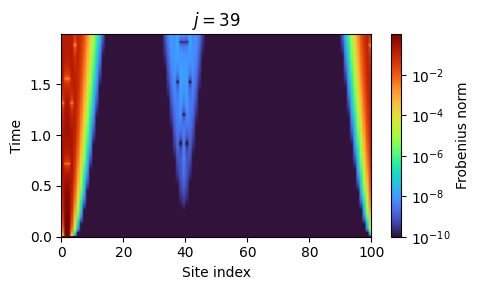

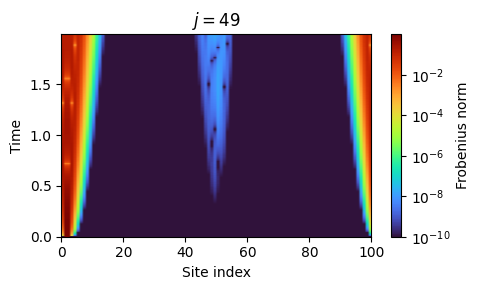

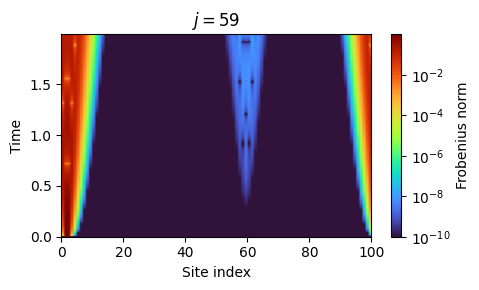

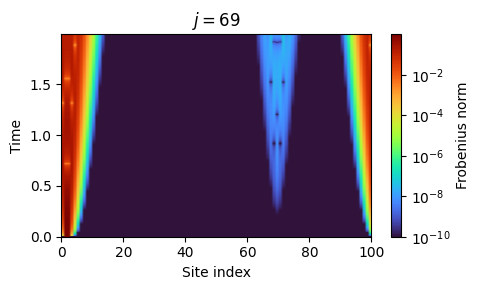

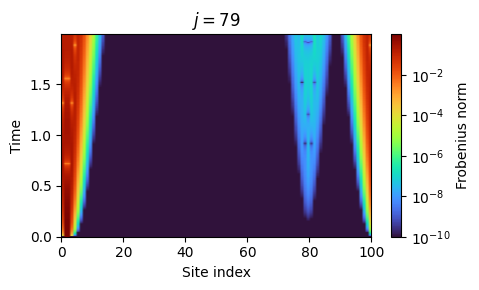

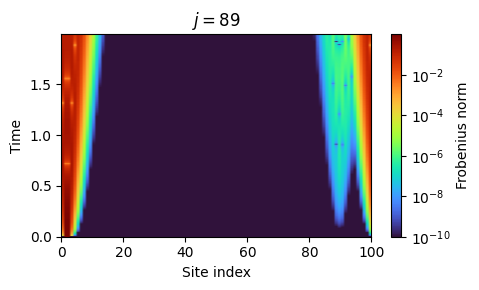

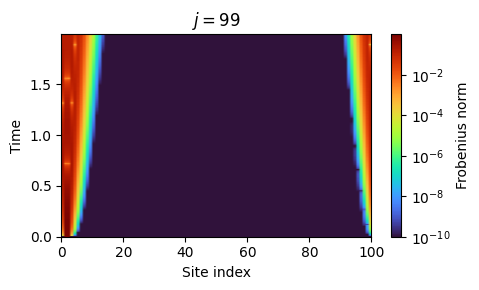

All plots saved in plt/static_profiles/


In [9]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np
import os

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

base_path = "src"
os.makedirs("plt/static_profiles", exist_ok=True)
Jlong_values = np.arange(9, 100, 10)
step_size = 0.01
steps_per_unit = 1 / step_size

for J in Jlong_values:
    file_path = os.path.join(base_path, f"N100LFIMb2lcfara05VaryPosPBC{J}.txt")
    raw_data = load_mathematica_data(file_path)
    time_axis = np.arange(raw_data.shape[0]) / steps_per_unit

    plt.figure(figsize=(5, 3))
    plt.imshow(
        np.clip(raw_data, 1e-11, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-10, vmax=np.nanmax(raw_data)),
        extent=[0, raw_data.shape[1], time_axis.min(), time_axis.max()],
        rasterized=True
    )
    plt.xlim(0,100)
    plt.title(fr"$j={J}$")
    plt.xlabel("Site index")
    plt.ylabel("Time")
    plt.colorbar(label="Frobenius norm")
    plt.tight_layout()
    # plt.savefig(f"plt/static_profiles/heatmap_J{J}.png", dpi=300)
    plt.show()
    plt.close()   # avoid memory buildup

print("All plots saved in plt/static_profiles/")


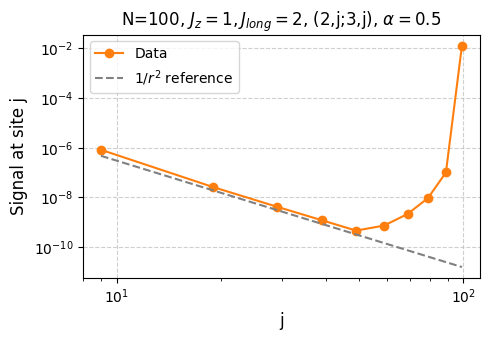

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os

base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 0.5

tracked_signal = []
Jlong_values = np.arange(9, 100,10)   # your sweep range
for J in Jlong_values:
    file_path = os.path.join(base_path, f"N100LFIMb2lcfara05VaryPosPBC{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    
    varyVariable = J
    signal_value = raw_data[t_index, varyVariable]
    tracked_signal.append(signal_value)

# Convert to arrays
J_array = np.array(Jlong_values)
tracked_signal = np.array(tracked_signal)

# --- Reference curve: 1/r^2 ---
A = tracked_signal[0] * (J_array[0]**2)  # normalization so it starts at same height
reference = 0.006 / (J_array**4.3)

# --- Plot ---
plt.figure(figsize=(5, 3.5))
plt.loglog(J_array, tracked_signal, "o-", color='C1', label="Data")
plt.loglog(J_array, reference, "--", color='gray', label=r"$1/r^2$ reference")

plt.xlabel("j", fontsize=12)
plt.ylabel("Signal at site j", fontsize=12)
plt.title(r"N=100, $J_z=1, J_{long}=2$, (2,j;3,j), $\alpha=0.5$", fontsize=12)
plt.grid(True, which="major", linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
# plt.savefig("plt/tracked_signal_vs_j_2.svg", dpi=150)
plt.show()



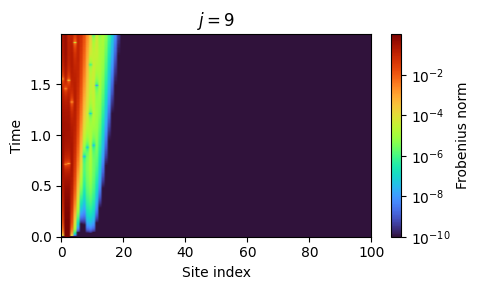

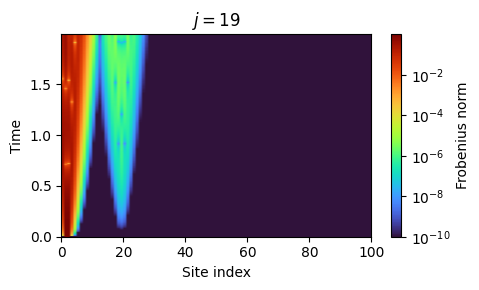

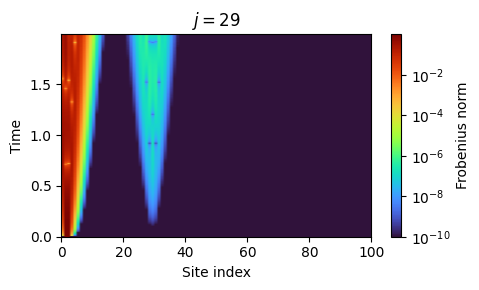

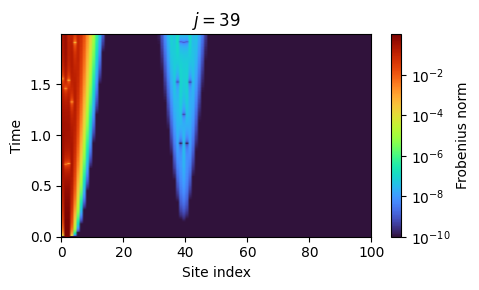

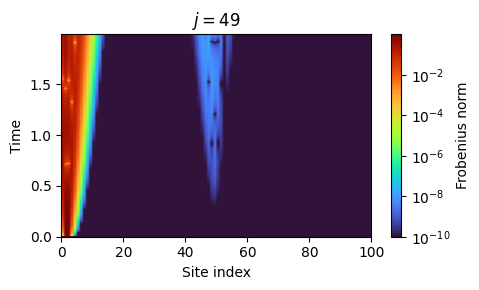

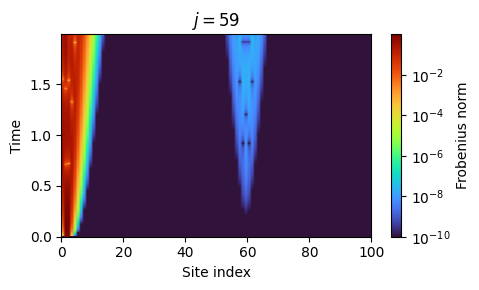

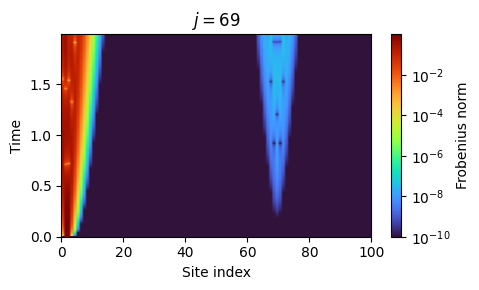

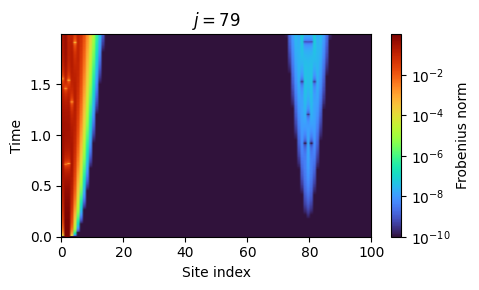

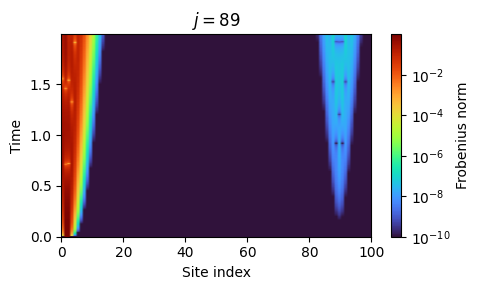

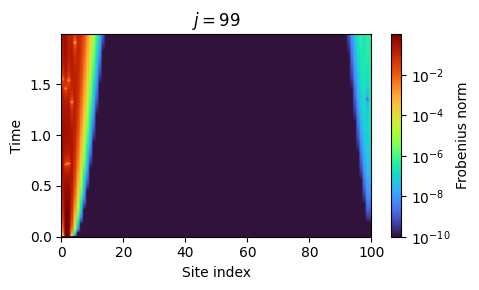

All plots saved in plt/static_profiles/


In [5]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np
import os

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

base_path = "src"
os.makedirs("plt/static_profiles", exist_ok=True)
Jlong_values = np.arange(9, 100, 10)
step_size = 0.01
steps_per_unit = 1 / step_size

for J in Jlong_values:
    file_path = os.path.join(base_path, f"N100LFIMb2lcfara05VaryPos{J}.txt")
    raw_data = load_mathematica_data(file_path)
    time_axis = np.arange(raw_data.shape[0]) / steps_per_unit

    plt.figure(figsize=(5, 3))
    plt.imshow(
        np.clip(raw_data, 1e-11, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-10, vmax=np.nanmax(raw_data)),
        extent=[0, raw_data.shape[1], time_axis.min(), time_axis.max()],
        rasterized=True
    )
    plt.xlim(0,100)
    plt.title(fr"$j={J}$")
    plt.xlabel("Site index")
    plt.ylabel("Time")
    plt.colorbar(label="Frobenius norm")
    plt.tight_layout()
    # plt.savefig(f"plt/static_profiles/heatmap_J{J}.png", dpi=300)
    plt.show()
    plt.close()   # avoid memory buildup

print("All plots saved in plt/static_profiles/")


C:\Users\shrey\AppData\Local\Temp\ipykernel_4252\608959801.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


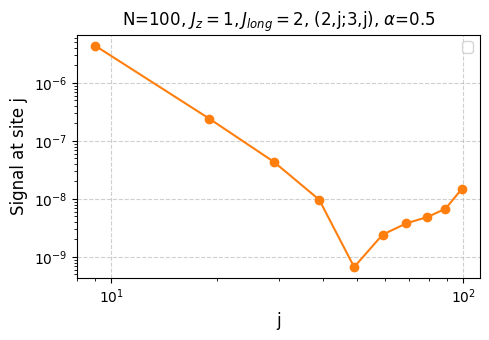

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 0.5



tracked_signal = []
Jlong_values = np.arange(9, 100,10)   # your sweep range
for J in Jlong_values:
    file_path = os.path.join(base_path, f"N100LFIMb2lcfara05VaryPos{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    
    # Extract the signal at varyVariable+2
    varyVariable = J   # or whatever your variable is
    signal_value = raw_data[t_index, varyVariable]
    tracked_signal.append(signal_value)

# Convert to NumPy arrays for plotting
J_array = np.array(Jlong_values)
tracked_signal = np.array(tracked_signal)

# --- Plot signal vs varyVariable ---
plt.figure(figsize=(5, 3.5))
plt.loglog(J_array, tracked_signal, "o-", color='C1')
plt.xlabel("j", fontsize=12)
plt.ylabel("Signal at site j", fontsize=12)
plt.title(r"N=100, $J_z=1, J_{long}=2$, (2,j;3,j), $\alpha$=0.5", fontsize=12)
plt.grid(True, which="major", linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("plt/tracked_signal_vs_j.svg", dpi=150)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 0.5

tracked_signal = []
Jlong_values = np.arange(1, 48)   # your sweep range
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05VaryPos{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    
    varyVariable = J
    signal_value = raw_data[t_index, varyVariable + 2]
    tracked_signal.append(signal_value)

# Convert to arrays
J_array = np.array(Jlong_values)
tracked_signal = np.array(tracked_signal)

# --- Reference curve: 1/r^2 ---
A = tracked_signal[0] * (J_array[0]**3)  # normalization so it starts at same height
reference = 0.001 / (J_array**3)

# --- Plot ---
plt.figure(figsize=(5, 3.5))
plt.semilogy(J_array, tracked_signal, "o-", color='C1', label="Data")
plt.semilogy(J_array, reference, "--", color='gray', label=r"$1/r^2$ reference")

plt.xlabel("j", fontsize=12)
plt.ylabel("Signal at site j", fontsize=12)
plt.title(r"N=50, $J_z=1, J_{long}=2$, (2,j;3,j), $\alpha=0.5$", fontsize=12)
plt.grid(True, which="major", linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
# plt.savefig("plt/tracked_signal_vs_j_2.svg", dpi=150)
plt.show()


In [31]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
import numpy as np
import os

# Assuming load_mathematica_data and constants are already defined above

os.makedirs("plt/varyPos", exist_ok=True)
frames = []

# --- Parameters ---
Jlong_values = np.arange(1, 48)   # your sweep range
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 1

def log_model(x, logA, a, p):
    return logA - a * (x ** p)

# Optional global fit reference (computed once)
all_x_fit, all_y_fit = [], []

for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05VaryPos{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 3:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Fit model to first few points
    n_fit = 8
    x_fit_points = sites[:n_fit]
    y_fit_points = profile[:n_fit]
    try:
        popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                            p0=(np.log(y_fit_points.max()), 0.01, 2.0))
        logA_fit, a_fit, p_fit = popt
        A_fit = np.exp(logA_fit)
        x_dense = np.linspace(1, max(x_fit_points), 300)
        y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)
    except Exception:
        x_dense, y_dense = [], []

    # --- Plot ---
    markers = ["x", "o", "^"]   # first = cross, rest = circles
    fig, ax = plt.subplots(figsize=(4.5, 3))
    ax.semilogy(
        sites, profile, "o-", markersize=5,
        markerfacecolor='none', markeredgecolor='C0', label=f"j={J}"
    )
    if len(x_dense):
        ax.semilogy(x_dense, y_dense, "c--", linewidth=1.5,
                    label=fr"Fit: $e^{{-{a_fit:.2f}x^{{{p_fit:.1f}}}}}$")

    ax.set_ylim(1e-10, 1)
    ax.set_xlim(0, 50)
    ax.set_xlabel("Site from crest", fontsize=12)
    ax.set_ylabel("Frobenius norm", fontsize=12)
    ax.set_title(fr"Outside Light Cone Profile, (2,{J+2};3,{J+2})", fontsize=12)
    ax.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
    ax.legend(fontsize=9, loc="upper right")
    plt.tight_layout()

    frame_path = f"plt/varyPos/frame_{J:02d}.png"
    plt.savefig(frame_path, dpi=150)
    plt.close(fig)
    frames.append(imageio.imread(frame_path))

# --- Create GIF ---
gif_path = "plt/profiles_evolution.gif"
imageio.mimsave(gif_path, frames, fps=5)
print(f"Saved animated profile GIF → {gif_path}")


Saved animated profile GIF → plt/profiles_evolution.gif


C:\Users\shrey\AppData\Local\Temp\ipykernel_33836\1571223069.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


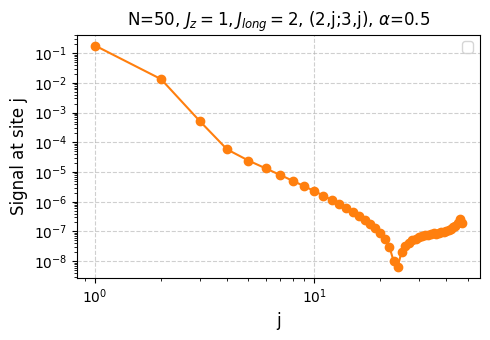

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 0.5



tracked_signal = []
Jlong_values = np.arange(1, 48)   # your sweep range
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05VaryPos{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    
    # Extract the signal at varyVariable+2
    varyVariable = J   # or whatever your variable is
    signal_value = raw_data[t_index, varyVariable+2]
    tracked_signal.append(signal_value)

# Convert to NumPy arrays for plotting
J_array = np.array(Jlong_values)
tracked_signal = np.array(tracked_signal)

# --- Plot signal vs varyVariable ---
plt.figure(figsize=(5, 3.5))
plt.loglog(J_array, tracked_signal, "o-", color='C1')
plt.xlabel("j", fontsize=12)
plt.ylabel("Signal at site j", fontsize=12)
plt.title(r"N=50, $J_z=1, J_{long}=2$, (2,j;3,j), $\alpha$=0.5", fontsize=12)
plt.grid(True, which="major", linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("plt/tracked_signal_vs_j.svg", dpi=150)
plt.show()


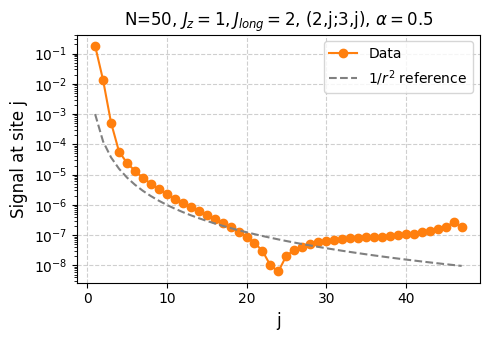

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os

base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 0.5

tracked_signal = []
Jlong_values = np.arange(1, 48)   # your sweep range
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05VaryPos{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    
    varyVariable = J
    signal_value = raw_data[t_index, varyVariable + 2]
    tracked_signal.append(signal_value)

# Convert to arrays
J_array = np.array(Jlong_values)
tracked_signal = np.array(tracked_signal)

# --- Reference curve: 1/r^2 ---
A = tracked_signal[0] * (J_array[0]**3)  # normalization so it starts at same height
reference = 0.001 / (J_array**3)

# --- Plot ---
plt.figure(figsize=(5, 3.5))
plt.semilogy(J_array, tracked_signal, "o-", color='C1', label="Data")
plt.semilogy(J_array, reference, "--", color='gray', label=r"$1/r^2$ reference")

plt.xlabel("j", fontsize=12)
plt.ylabel("Signal at site j", fontsize=12)
plt.title(r"N=50, $J_z=1, J_{long}=2$, (2,j;3,j), $\alpha=0.5$", fontsize=12)
plt.grid(True, which="major", linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
# plt.savefig("plt/tracked_signal_vs_j_2.svg", dpi=150)
plt.show()


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = np.array([2,3,4])
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 1

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
# all_max = 0
# for J in Jlong_values:
#     data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{Jlong_values}.txt"))
#     all_max = max(all_max, np.nanmax(data))
arrivals = [
    (4, 0.15), (5, 0.57), (6, 1.06), (7, 1.57)
]
x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times
# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
# x_fit = np.linspace(x_points.min(), x_points.max(), 200)
x_fit = np.linspace(3.9, 7.7, 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")
# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05Varyb{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 3))
    im = plt.imshow(
        np.clip(raw_data, 1e-11, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-10, vmax=np.nanmax(raw_data)),
        interpolation="nearest",
        extent=[0, raw_data.shape[1], t_min, t_max],
        rasterized=True
    )
    # Overlay first arrival points
    plt.plot(x_points, y_points, 'wo', markersize=7,
            markeredgecolor="k", label="First arrivals")

    # Overlay best-fit line
    plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

    label = {2: "(a)", 3: "(b)", 4: "(c)"}[J]

    plt.text(
        0.02, 0.95, label,
        transform=plt.gca().transAxes,
        fontsize=14, fontweight="bold",
        va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

    plt.colorbar(im, label="Frobenius norm")
    plt.xlabel("Site index", fontsize=12)
    plt.ylabel("Time", fontsize=12)
    plt.xlim(0, 50)
    if J == 2:
        plt.title(fr"(2,20;3,20) Jlong=2, Jz=1, $\alpha$=0.5", fontsize=12)
    if J==3:
        plt.title(fr"(2,20,40;3,20,40) Jlong=2, Jz=1, $\alpha$=0.5", fontsize=12)
    if J==4:
        plt.title(fr"(2,20,40;3,20,40) Jlong=2, Jz=1, $\alpha\to\infty$", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plt/Heatmap_b{J}.svg", dpi=600)
    plt.show()


# -----------------------------
# Profiles overlayed on one plot + global fit
# -----------------------------
plt.figure(figsize=(4.5, 3))
# High-contrast RGB colors (normalized to [0,1])
colors = [
    (0.10, 0.47, 0.88),  # bright blue
    (0.90, 0.17, 0.31),  # red/pink
    (0.00, 0.60, 0.30)   # greenish teal
]


all_x_fit = []
all_y_fit = []

letters= ['(a)', '(b)', '(c)']
let=0
# for J, c in zip(Jlong_values, colors):
#     file_path = os.path.join(base_path, f"B0LFIMb2lcfara05Varyb{J}.txt")
#     raw_data = load_mathematica_data(file_path)
#     n_steps = raw_data.shape[0]
#     t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
#     profile = raw_data[t_index, 3:]
#     sites = np.arange(1, profile.size + 1)
#     mask = profile > 1e-14
#     sites, profile = sites[mask], profile[mask]

#     # Collect first few points for a single global fit
#     n_fit =8
#     all_x_fit.extend(sites[:n_fit])
#     all_y_fit.extend(profile[:n_fit])
#     plt.semilogy(
#     sites, profile, "o",
#     markerfacecolor='none',     # open circles (no fill)
#     markeredgecolor=c,          # colored edges
#     markersize=5,
#     label=fr"$b$={J:.0f}"
#     )   
#     let+=1

# Define distinct markers
markers = ["x", "o", "^"]   # first = cross, rest = circles

for (J, c, m) in zip(Jlong_values, colors, markers):
    file_path = os.path.join(base_path, f"B0LFIMb2lcfara05VaryPos{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    t_index = min(int(time_for_profile * steps_per_unit), n_steps - 1)
    profile = raw_data[t_index, 3:]
    sites = np.arange(1, profile.size + 1)
    mask = profile > 1e-14
    sites, profile = sites[mask], profile[mask]

    # Collect first few points for a single global fit
    n_fit = 8
    all_x_fit.extend(sites[:n_fit])
    all_y_fit.extend(profile[:n_fit])
    if J == 4:
        label = r"$b=3, \alpha\to\infty$"
    else:
        label = fr"$b$={J:.0f}, $\alpha=0.5$"

    plt.semilogy(
        sites, profile, m,
        markerfacecolor='none',     # open symbols
        markeredgecolor=c,
        markersize=6,
        linewidth=1.2,
        label=label
    )


# -----------------------------
# Fit single model to combined early points
# -----------------------------
def log_model(x, logA, a, p):
    return logA - a * (x ** p)

x_fit_points = np.array(all_x_fit)
y_fit_points = np.array(all_y_fit)
mask = y_fit_points > 1e-14
x_fit_points, y_fit_points = x_fit_points[mask], y_fit_points[mask]

popt, _ = curve_fit(log_model, x_fit_points, np.log(y_fit_points),
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Compute global fit curve
x_dense = np.linspace(1, max(x_fit_points), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense ** p_fit)

# Add the single global fit to the same plot
plt.semilogy(x_dense, y_dense, "c--", linewidth=2,
             label=fr"Fit: ${A_fit:.1f}e^{{-{a_fit:.1f}x^{{{p_fit:.1f}}}}}$")

# Final formatting
plt.ylim(1e-10, 1)
plt.xlim(0, 50)
plt.xlabel("Site from crest", fontsize=12)
plt.ylabel("Frobenius norm", fontsize=12)
plt.title(f"Outside Light Cone Profiles at t={time_for_profile}", fontsize=12)
# --- Add gridlines ---
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(fontsize=9, loc="upper right")
plt.tight_layout()
plt.show()


## B-Jlong

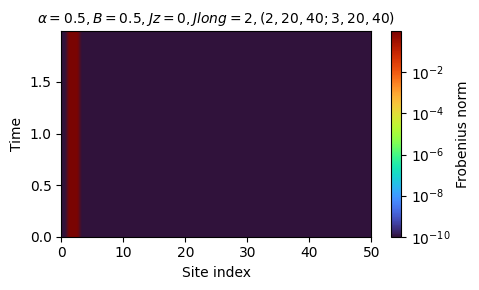

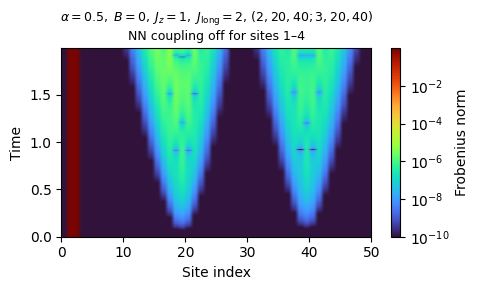

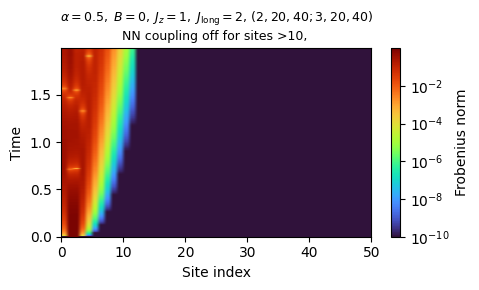

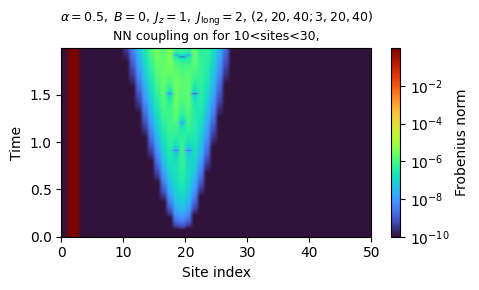

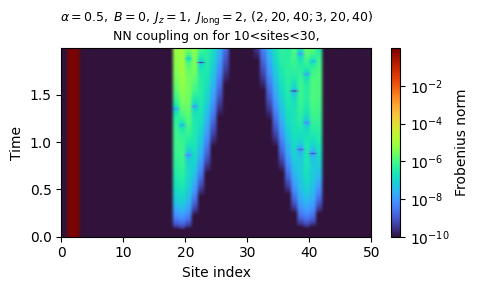

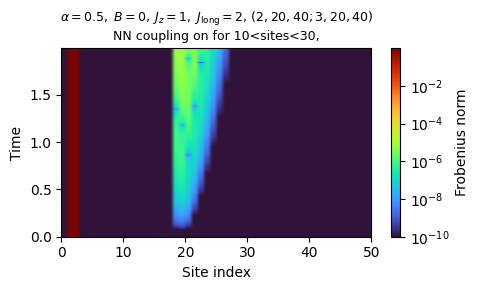

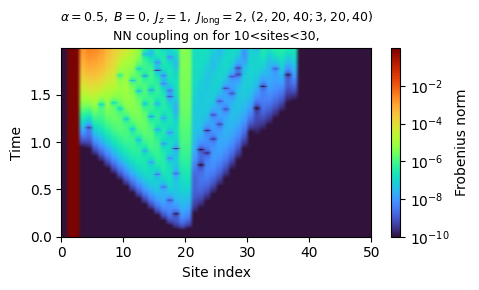

All plots saved in plt/


In [2]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np
import os

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

base_path = "src"
os.makedirs("plt/static_profiles", exist_ok=True)
Jlong_values = [0,1,2,3,4,5,6]
step_size = 0.01
steps_per_unit = 1 / step_size

for J in Jlong_values:
    file_path = os.path.join(base_path, f"BJlongb3{J}.txt")
    raw_data = load_mathematica_data(file_path)
    time_axis = np.arange(raw_data.shape[0]) / steps_per_unit

    plt.figure(figsize=(5, 3))
    plt.imshow(
        np.clip(raw_data, 1e-11, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-10, vmax=np.nanmax(raw_data)),
        extent=[0, raw_data.shape[1], time_axis.min(), time_axis.max()],
        rasterized=True
    )
    plt.xlim(0,50)
    if J==0:
        plt.title(fr"$\alpha=0.5, B=0.5, Jz=0, Jlong=2, (2,20,40;3,20,40)$", fontsize=10)
    if J==1:
        plt.title(r"$\alpha = 0.5,\; B = 0,\; J_z = 1,\; J_{\mathrm{long}} = 2$, $(2,20,40;3,20,40)$"
          "\nNN coupling off for sites 1–4", fontsize=9)
    if J==2:
        plt.title(r"$\alpha = 0.5,\; B = 0,\; J_z = 1,\; J_{\mathrm{long}} = 2$, $(2,20,40;3,20,40)$"
          "\nNN coupling off for sites >10, ", fontsize=9)
    if J==3:
        plt.title(r"$\alpha = 0.5,\; B = 0,\; J_z = 1,\; J_{\mathrm{long}} = 2$, $(2,20,40;3,20,40)$"
          "\nNN coupling on for 10<sites<30,", fontsize=9)
    if J==4:
        plt.title(r"$\alpha = 0.5,\; B = 0,\; J_z = 1,\; J_{\mathrm{long}} = 2$, $(2,20,40;3,20,40)$"
          "\nNN coupling on for 10<sites<30,", fontsize=9)
    if J==5:
        plt.title(r"$\alpha = 0.5,\; B = 0,\; J_z = 1,\; J_{\mathrm{long}} = 2$, $(2,20,40;3,20,40)$"
          "\nNN coupling on for 10<sites<30,", fontsize=9)
    if J==6:
        plt.title(r"$\alpha = 0.5,\; B = 0,\; J_z = 1,\; J_{\mathrm{long}} = 2$, $(2,20,40;3,20,40)$"
          "\nNN coupling on for 10<sites<30,", fontsize=9)
    plt.xlabel("Site index")
    plt.ylabel("Time")
    plt.colorbar(label="Frobenius norm")
    plt.tight_layout()
    plt.savefig(f"plt/heatmap_BJlong{J}.png", dpi=300)
    plt.show()
    plt.close()   # avoid memory buildup

print("All plots saved in plt/")


Fit slope = 0.475, intercept = -1.775


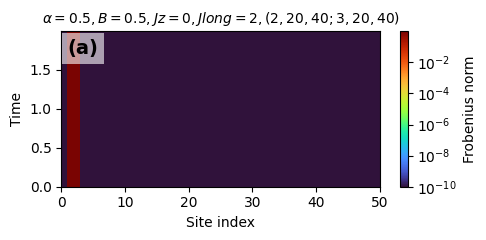

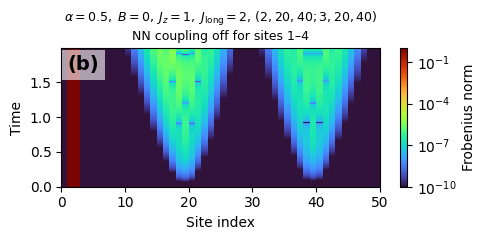

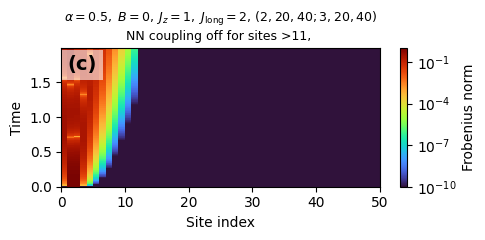

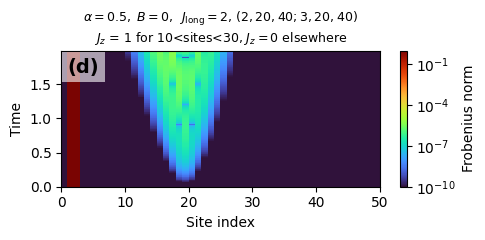

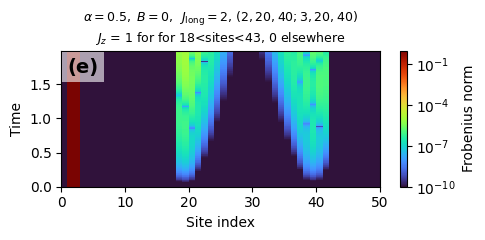

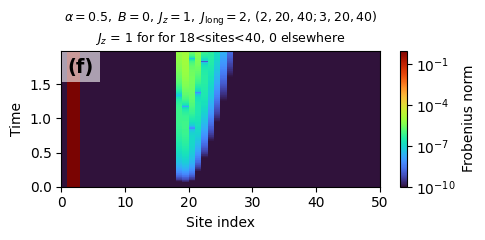

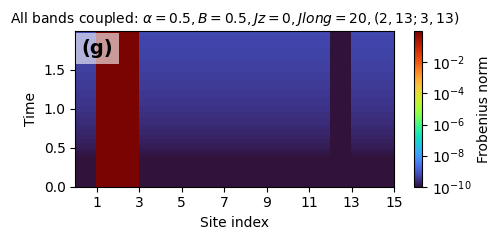

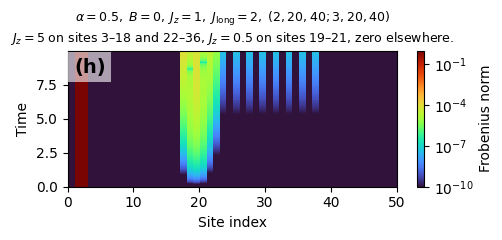

In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# -----------------------------
# Load Mathematica-style text files
# -----------------------------
def load_mathematica_data(filename):
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.replace("*^", "e").strip().lstrip("{").rstrip("}")
            if not line:
                continue
            entries = line.split(",")
            row = []
            for e in entries:
                e = e.strip()
                if "+ 0." in e:
                    e = e.split("+")[0].strip()
                if "*I" in e:
                    continue
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)

# -----------------------------
# Settings
# -----------------------------
Jlong_values = np.array([0,1,2,3,4,5,7,6])
base_path = "src"
step_size = 0.01
steps_per_unit = 1 / step_size
time_for_profile = 1

os.makedirs("plt", exist_ok=True)

# Precompute consistent color scale
# all_max = 0
# for J in Jlong_values:
#     data = load_mathematica_data(os.path.join(base_path, f"B0LFIMb2lcfara05VaryNWscaling{Jlong_values}.txt"))
#     all_max = max(all_max, np.nanmax(data))
arrivals = [
    (4, 0.15), (5, 0.57), (6, 1.06), (7, 1.57)
]
x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times
# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
# x_fit = np.linspace(x_points.min(), x_points.max(), 200)
x_fit = np.linspace(3.9, 7.7, 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params
print(f"Fit slope = {slope:.3f}, intercept = {intercept:.3f}")
# -----------------------------
# Generate three heatmaps
# -----------------------------
for J in Jlong_values:
    file_path = os.path.join(base_path, f"BJlongb3{J}.txt")
    raw_data = load_mathematica_data(file_path)
    n_steps = raw_data.shape[0]
    time_axis = np.arange(n_steps) / steps_per_unit
    t_min, t_max = time_axis.min(), time_axis.max()

    plt.figure(figsize=(5, 2.5))
    im = plt.imshow(
        np.clip(raw_data, 1e-11, None),
        aspect="auto",
        origin="lower",
        cmap="turbo",
        norm=mcolors.LogNorm(vmin=1e-10, vmax=np.nanmax(raw_data)),
        interpolation="nearest",
        extent=[0, raw_data.shape[1], t_min, t_max],
        rasterized=True
    )
    # Overlay first arrival points
    # plt.plot(x_points, y_points, 'wo', markersize=7,
    #         markeredgecolor="k", label="First arrivals")

    # Overlay best-fit line
    # plt.plot(x_fit, y_fit, 'k--', linewidth=2, label="Linear fit")

    label_dict = {j: f"({chr(96 + i)})" for i, j in enumerate(Jlong_values, start=1)}
    label = label_dict.get(J, "(?)")


    plt.text(
        0.02, 0.95, label,
        transform=plt.gca().transAxes,
        fontsize=14, fontweight="bold",
        va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

    plt.xlim(0,50)
    if J==0:
        plt.title(fr"$\alpha=0.5, B=0.5, Jz=0, Jlong=2, (2,20,40;3,20,40)$", fontsize=10)
    if J==1:
        plt.title(r"$\alpha = 0.5,\; B = 0,\; J_z = 1,\; J_{\mathrm{long}} = 2$, $(2,20,40;3,20,40)$"
          "\nNN coupling off for sites 1–4", fontsize=9)
    if J==2:
        plt.title(r"$\alpha = 0.5,\; B = 0,\; J_z = 1,\; J_{\mathrm{long}} = 2$, $(2,20,40;3,20,40)$"
          "\nNN coupling off for sites >11, ", fontsize=9)
    if J==3:
        plt.title(r"$\alpha = 0.5,\; B = 0,\; \; J_{\mathrm{long}} = 2$, $(2,20,40;3,20,40)$"
          "\n$J_z$ = 1 for 10<sites<30, $J_z=0$ elsewhere", fontsize=9)
    if J==4:
        plt.title(r"$\alpha = 0.5,\; B = 0,\;\; J_{\mathrm{long}} = 2$, $(2,20,40;3,20,40)$"
          "\n$J_z$ = 1 for for 18<sites<43, 0 elsewhere", fontsize=9)
    if J==5:
        plt.title(r"$\alpha = 0.5,\; B = 0,\; J_z = 1,\; J_{\mathrm{long}} = 2$, $(2,20,40;3,20,40)$"
          "\n$J_z$ = 1 for for 18<sites<40, 0 elsewhere", fontsize=9)
    if J==7:
        plt.xlim(0,15)
        plt.xticks(np.arange(1,16,2))
        plt.title(fr"All bands coupled: $\alpha=0.5, B=0.5, Jz=0, Jlong=20, (2,13;3,13)$", fontsize=10)

    if J==6:
        plt.title(
            r"$\alpha = 0.5,\; B = 0,\; J_z = 1,\; J_{\mathrm{long}} = 2,\; (2,20,40;3,20,40)$"
            "\n"
            r"$J_z=5$ on sites $3$–$18$ and $22$–$36$, "
            r"$J_z=0.5$ on sites $19$–$21$, zero elsewhere.",
            fontsize=9
        )
    
    plt.xlabel("Site index")
    plt.ylabel("Time")
    plt.colorbar(label="Frobenius norm")
    plt.tight_layout()
    plt.savefig(f"plt/heatmap_BJlong{J}.svg", dpi=300)
    plt.show()
    plt.close()   # avoid memory buildup

